In [1]:
%run data_preparation.ipynb

Accessible dataframes    Description                            # of columns  
data_2019                Gives data for 2019-Baseline           15
data_2023                Gives data for 2023                    13
data_2024                Gives data for 2024                    13
station_data             Existing stations in NYC from Lyft      6


In [2]:
file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2020.pkl"
data_2020 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2021.pkl"
data_2021 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2022.pkl"
data_2022 = pd.read_pickle(file_name)

In [3]:
data_2021.iloc[:3]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2513.0,2021-01-01 00:00:11.9020,2021-01-01 00:42:05.2260,3581.0,Underhill Ave & Lincoln Pl,40.674012,-73.967146,3581.0,Underhill Ave & Lincoln Pl,40.674012,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2519.0,2021-01-01 00:00:15.0960,2021-01-01 00:42:14.9780,3581.0,Underhill Ave & Lincoln Pl,40.674012,-73.967146,3581.0,Underhill Ave & Lincoln Pl,40.674012,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1207.0,2021-01-01 00:00:28.9300,2021-01-01 00:20:36.6510,3144.0,E 81 St & Park Ave,40.776777,-73.959010,3724.0,7 Ave & Central Park South,40.766741,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_2021.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'ride_id', 'rideable_type', 'started_at',
       'ended_at', 'start_station_name', 'start_station_id',
       'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
       'end_lat', 'end_lng', 'member_casual'],
      dtype='object')

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# from fbprophet import Prophet
# import keras

### Load weather data

In [6]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2019-01-01",
	"end_date": "2024-01-31",
	"hourly": ["relative_humidity_2m", "apparent_temperature", "precipitation", "wind_speed_100m"],
	"daily": ["daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_daylight_duration = daily.Variables(0).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours

daily_dataframe = pd.DataFrame(data = daily_data)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  relative_humidity_2m  apparent_temperature  \
0     2019-01-01 00:00:00+00:00             94.910034              1.515067   
1     2019-01-01 01:00:00+00:00             94.608643              1.826883   
2     2019-01-01 02:00:00+00:00             94.625481              1.944422   
3     2019-01-01 03:00:00+00:00             94.650566              2.240760   
4     2019-01-01 04:00:00+00:00             95.662788              4.225030   
...                         ...                   ...                   ...   
44563 2024-01-31 19:00:00+00:00             62.851669              0.719935   
44564 2024-01-31 20:00:00+00:00             63.751801              0.732302   
44565 2024-01-31 21:00:00+00:00             64.212799              0.828812   
44566 2024-01-31 22:00:00+00:00             67.990280              0.181266   
4456

In [7]:
daily_dataframe.columns

Index(['date', 'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours'],
      dtype='object')

In [8]:
data_2019.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [9]:
# Select only the necessary columns
data_2019_s = data_2019[['starttime']]
data_2019_s = data_2019_s.rename(columns={'starttime': 'started_at'})
data_2020_s = data_2020[['starttime']]
data_2020_s = data_2020_s.rename(columns={'starttime': 'started_at'})
data_2021_s = data_2021[['started_at']]
data_2022_s = data_2022[['started_at']]
data_2023_s = data_2023[['started_at']]
data_2024_s = data_2024[['started_at']]

In [27]:
all_data = pd.concat([data_2019_s, data_2020_s,data_2021_s,data_2022_s, data_2023_s, data_2024_s], ignore_index=True) # data_2019_s, data_2020_s, 
all_data = all_data.sort_values(by='started_at')

# Define chunk size
chunk_size = 1000000  # Adjust chunk size as needed

# Initialize an empty list to store results
chunks = []

# Process the DataFrame in chunks
for chunk_start in range(0, len(all_data), chunk_size):
    chunk_end = min(chunk_start + chunk_size, len(all_data))
    chunk = all_data.iloc[chunk_start:chunk_end]
    
    # Group by date and calculate the number of rides for each date in the chunk
    chunk_rides_per_date = chunk.groupby(chunk['started_at'].dt.date).size().reset_index(name='rides')
    
    # Append the chunk result to the list of chunks
    chunks.append(chunk_rides_per_date)

# Concatenate results
rides_per_date = pd.concat(chunks, ignore_index=True)

# Display the rides_per_date DataFrame
len(rides_per_date)

1960

In [61]:
len(all_data)

136590902

In [64]:
len(data_2019)

20551697

In [20]:
rides_per_date

,started_at,rides
0,2021-02-01,249.0
1,2021-02-02,3368.5
2,2021-02-03,6488.0
3,2021-02-04,18792.0
4,2021-02-05,24378.0
...,...,...
1090,2024-01-27,83126.0
1091,2024-01-28,30521.0
1092,2024-01-29,73131.0
1093,2024-01-30,80777.0


In [28]:
rides_per_date['started_at'] = pd.to_datetime(rides_per_date['started_at'])
rides_per_date = rides_per_date.set_index('started_at').sort_index()

# Resample to fill missing dates and calculate the average of rides
rides_per_date = rides_per_date.resample('D').mean().interpolate(method='linear')
rides_per_date.reset_index(inplace=True)

In [29]:
# rides_per_date.reset_index(inplace=True)
rides_per_date

,started_at,rides
0,2019-01-01,21962.0
1,2019-01-02,37797.0
2,2019-01-03,41676.0
3,2019-01-04,43922.0
4,2019-01-05,17432.0
...,...,...
1852,2024-01-27,83126.0
1853,2024-01-28,30521.0
1854,2024-01-29,73131.0
1855,2024-01-30,80777.0


In [30]:
daily_dataframe

,date,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours
0,2019-01-01 00:00:00+00:00,33519.910156,16687.349609,21.500000,21.500000,0.0,8.0
1,2019-01-02 00:00:00+00:00,33564.589844,18708.148438,0.000000,0.000000,0.0,0.0
2,2019-01-03 00:00:00+00:00,33613.390625,21817.695312,0.000000,0.000000,0.0,0.0
3,2019-01-04 00:00:00+00:00,33666.207031,24447.589844,0.000000,0.000000,0.0,0.0
4,2019-01-05 00:00:00+00:00,33722.902344,0.000000,20.000000,20.000000,0.0,18.0
...,...,...,...,...,...,...,...
1852,2024-01-27 00:00:00+00:00,35740.281250,12562.403320,0.000000,0.000000,0.0,0.0
1853,2024-01-28 00:00:00+00:00,35863.019531,0.000000,20.800003,20.800003,0.0,19.0
1854,2024-01-29 00:00:00+00:00,35987.292969,20462.386719,1.200000,1.200000,0.0,10.0
1855,2024-01-30 00:00:00+00:00,36112.960938,27167.109375,0.000000,0.000000,0.0,0.0


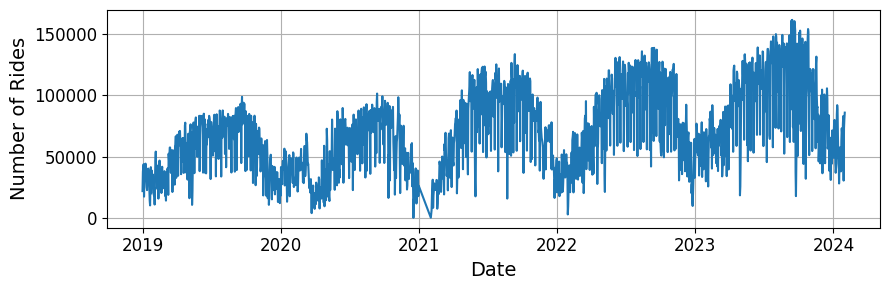

In [31]:
# Plotting
plt.figure(figsize=(9, 3))
plt.plot(rides_per_date['started_at'], rides_per_date['rides'], linestyle='-')
# plt.title('Number of Rides per Day')
plt.xlabel('Date', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('Number of Rides', fontsize=14)  # Increase font size for y-axis label
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
# plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

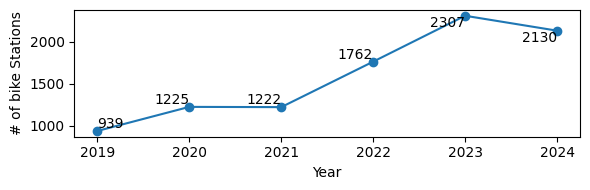

In [32]:
# Calculate the number of unique bike stations for each year
years = range(2019, 2025)
bike_stations = []

for year in years:
    # Determine the column name based on the year
    column_name = 'start station name' if year < 2022 else 'start_station_name'
    # Calculate the number of unique bike stations
    num_stations = len(globals()[f"data_{year}"][column_name].unique())
    bike_stations.append(num_stations)

# Plotting
plt.figure(figsize=(6., 2))
plt.plot(years, bike_stations, marker='o', linestyle='-')
# plt.title('Increase in Bike Stations Over Time')
plt.xlabel('Year')
plt.ylabel('# of bike Stations')
plt.grid(False)
plt.xticks(years)  # Set the x-axis ticks to be the years

# Display specific numbers

for i, txt in enumerate(bike_stations):
    if i==0:
        plt.text(years[i], bike_stations[i], str(txt), ha='left', va='bottom')
    elif 0<i<4:
        plt.text(years[i], bike_stations[i], str(txt), ha='right', va='bottom')
    elif i>=4:
        plt.text(years[i], bike_stations[i], str(txt), ha='right', va='top')

plt.tight_layout()
plt.show()

In [33]:
# Convert the 'started_at' column to datetime if it's not already
rides_per_date['started_at'] = pd.to_datetime(rides_per_date['started_at'])

# Group by year and sum the rides
rides_per_year = rides_per_date.groupby(rides_per_date['started_at'].dt.year)['rides'].sum().reset_index()

# Rename columns for clarity
rides_per_year.columns = ['Year', 'Total Rides']

In [44]:
rides_per_year = rides_per_year.iloc[:-1,:]

In [45]:
bike_stations = bike_stations[:-1]
bike_stations

[939, 1225, 1222, 1762, 2307]

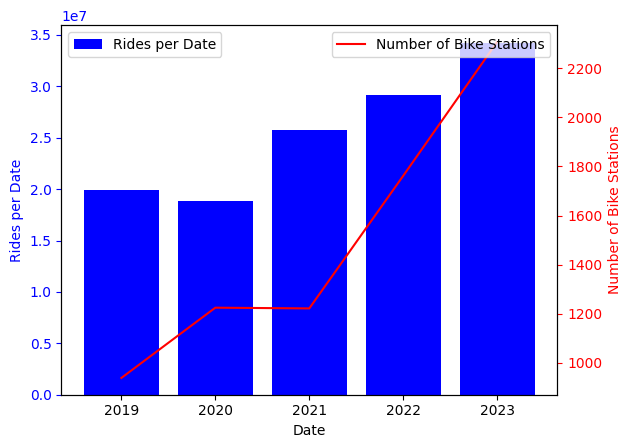

In [48]:
fig, ax1 = plt.subplots()

# Plot rides_per_date on the first y-axis
ax1.bar(rides_per_year['Year'], rides_per_year['Total Rides'], color='b', label='Rides per Date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rides per Date', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot bike_stations on the second y-axis
ax2.plot(rides_per_year['Year'], bike_stations, color='r', label='Number of Bike Stations')
ax2.set_ylabel('Number of Bike Stations', color='r')
ax2.tick_params('y', colors='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()

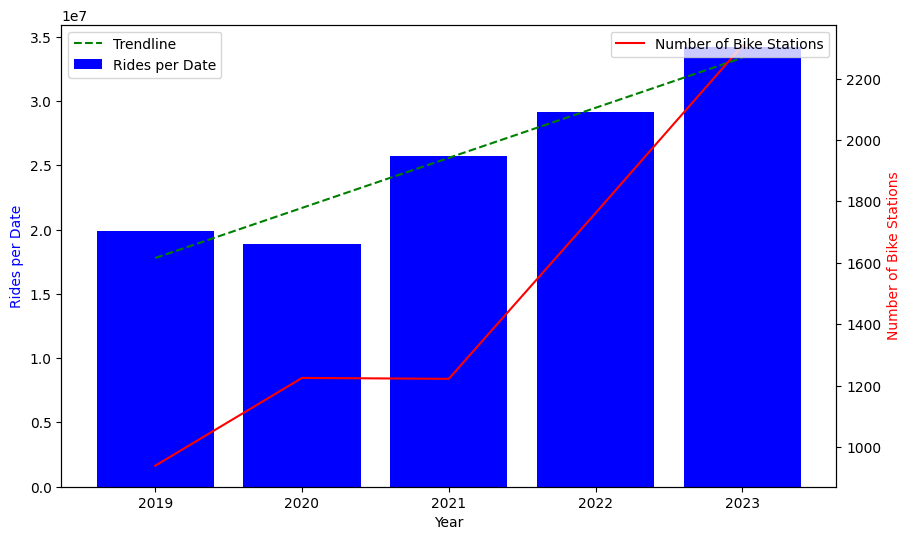

In [58]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot rides_per_date as a bar plot on the first y-axis
ax1.bar(rides_per_year['Year'], rides_per_year['Total Rides'], color='b', label='Rides per Date')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rides per Date', color='b')

# Fit a linear regression model to rides_per_date
X = np.array(range(len(rides_per_year))).reshape(-1, 1)  # Reshape X to be 2D
y = rides_per_year['Total Rides']
model = LinearRegression().fit(X, y)

# Predict values using the linear regression model
y_pred = model.predict(X)

# Plot the trendline
ax1.plot(rides_per_year['Year'], y_pred, color='g', linestyle='--', label='Trendline')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot bike_stations on the second y-axis as a line plot
ax2.plot(rides_per_year['Year'], bike_stations, color='r', label='Number of Bike Stations')
ax2.set_ylabel('Number of Bike Stations', color='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


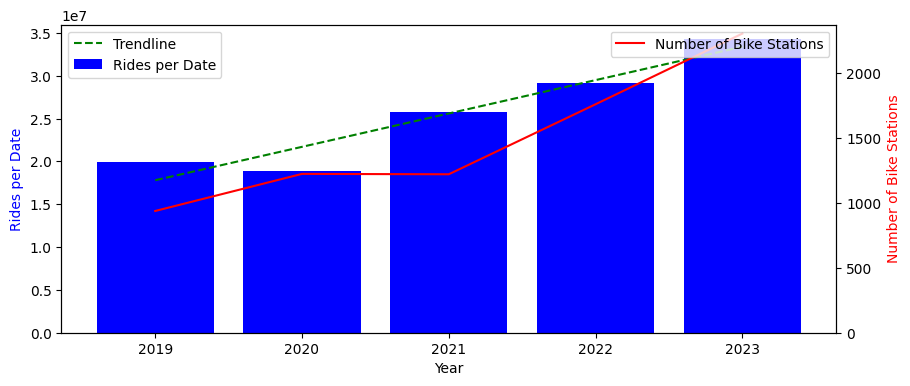

In [60]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot rides_per_date as a bar plot on the first y-axis
ax1.bar(rides_per_year['Year'], rides_per_year['Total Rides'], color='b', label='Rides per Date')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rides per Date', color='b')

# Fit a linear regression model to rides_per_date
X = np.array(range(len(rides_per_year))).reshape(-1, 1)  # Reshape X to be 2D
y = rides_per_year['Total Rides']
model = LinearRegression().fit(X, y)

# Predict values using the linear regression model
y_pred = model.predict(X)

# Plot the trendline
ax1.plot(rides_per_year['Year'], y_pred, color='g', linestyle='--', label='Trendline')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot bike_stations on the second y-axis as a line plot
ax2.plot(rides_per_year['Year'], bike_stations, color='r', label='Number of Bike Stations')
ax2.set_ylabel('Number of Bike Stations', color='r')

# Set y-axis limits to start from 0 for both axes
ax1.set_ylim(0)
ax2.set_ylim(0)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


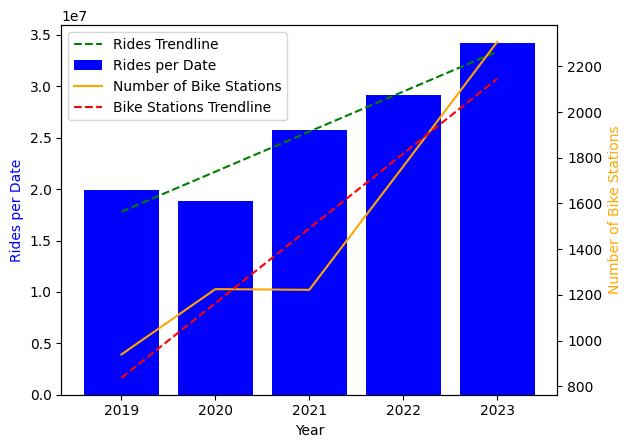

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming you have already calculated rides_per_date, rides_per_year, and bike_stations

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot rides_per_date as a bar plot on the first y-axis
ax1.bar(rides_per_year['Year'], rides_per_year['Total Rides'], color='b', label='Rides per Date')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rides per Date', color='b')

# Fit a linear regression model to rides_per_date
X_rides = np.array(range(len(rides_per_year))).reshape(-1, 1)  # Reshape X to be 2D
y_rides = rides_per_year['Total Rides']
rides_model = LinearRegression().fit(X_rides, y_rides)

# Predict values using the linear regression model for rides_per_date
y_rides_pred = rides_model.predict(X_rides)

# Plot the trendline for rides_per_date on ax1
ax1.plot(rides_per_year['Year'], y_rides_pred, color='g', linestyle='--', label='Rides Trendline')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot bike_stations on the second y-axis as a line plot
ax2.plot(rides_per_year['Year'], bike_stations, color='orange', label='Number of Bike Stations')
ax2.set_ylabel('Number of Bike Stations', color='orange')

# Fit a linear regression model to bike_stations
X_bike = np.array(range(len(bike_stations))).reshape(-1, 1)  # Reshape X to be 2D
y_bike = bike_stations
bike_model = LinearRegression().fit(X_bike, y_bike)

# Predict values using the linear regression model for bike_stations
y_bike_pred = bike_model.predict(X_bike)

# Plot the trendline for bike_stations on ax2
ax2.plot(rides_per_year['Year'], y_bike_pred, color='r', linestyle='--', label='Bike Stations Trendline')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.show()


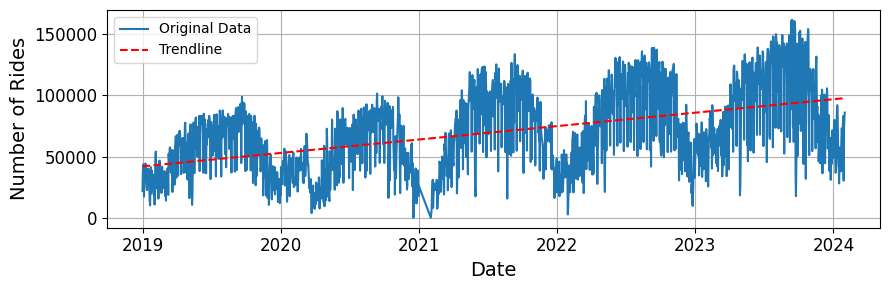

In [37]:

# Convert 'started_at' column to datetime type
rides_per_date['started_at'] = pd.to_datetime(rides_per_date['started_at'])

# Convert dates to numerical values
start_date = rides_per_date['started_at'].min()
x_numeric = (rides_per_date['started_at'] - start_date).dt.days.values

# Plotting
plt.figure(figsize=(9, 3))

# Plot the original data
plt.plot(rides_per_date['started_at'], rides_per_date['rides'], linestyle='-', label='Original Data')

# Fit a polynomial regression line (trendline)
y = rides_per_date['rides'].values
degree = 1  # Linear trendline
coefficients = np.polyfit(x_numeric, y, degree)
trendline = np.poly1d(coefficients)
plt.plot(rides_per_date['started_at'], trendline(x_numeric), color='red', linestyle='--', label='Trendline')

plt.xlabel('Date', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('Number of Rides', fontsize=14)  # Increase font size for y-axis label
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.grid(True)
plt.tight_layout()
plt.legend()  # Show legend
plt.show()

In [38]:
rides_per_date['started_at']

0      2019-01-01
1      2019-01-02
2      2019-01-03
3      2019-01-04
4      2019-01-05
          ...    
1852   2024-01-27
1853   2024-01-28
1854   2024-01-29
1855   2024-01-30
1856   2024-01-31
Name: started_at, Length: 1857, dtype: datetime64[ns]

In [ ]:

# Convert 'started_at' to datetime if not already done
# rides_per_date['started_at'] = pd.to_datetime(rides_per_date['started_at'])

# Sort the dataframe by 'started_at' to ensure chronological order
rides_per_date = rides_per_date.sort_values(by='started_at')

# Set the date from which you want to split the data
split_date = '2023-01-01'

# Split the data into training and testing sets
train_data = rides_per_date[rides_per_date['started_at'] < split_date]
test_data = rides_per_date[rides_per_date['started_at'] >= split_date]

In [119]:

# Assuming rides_per_date is your dataframe containing 'started_at' and 'rides' columns
# Preprocess your data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(rides_per_date['rides'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Define the number of time steps to look back
look_back = 30  # You can adjust this value based on your data and requirements

# Function to create dataset with look back
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Create dataset with look back
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Evaluate your model
# You can use various metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), etc.
# Evaluate your model using these metrics based on your problem requirements.

Epoch 1/100


C:\Users\lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0688
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0150
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0152
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0138
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0156
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0148
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0146
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0138
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0135
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0143
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0144
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0145
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0141
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0141
E

C:\Users\lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


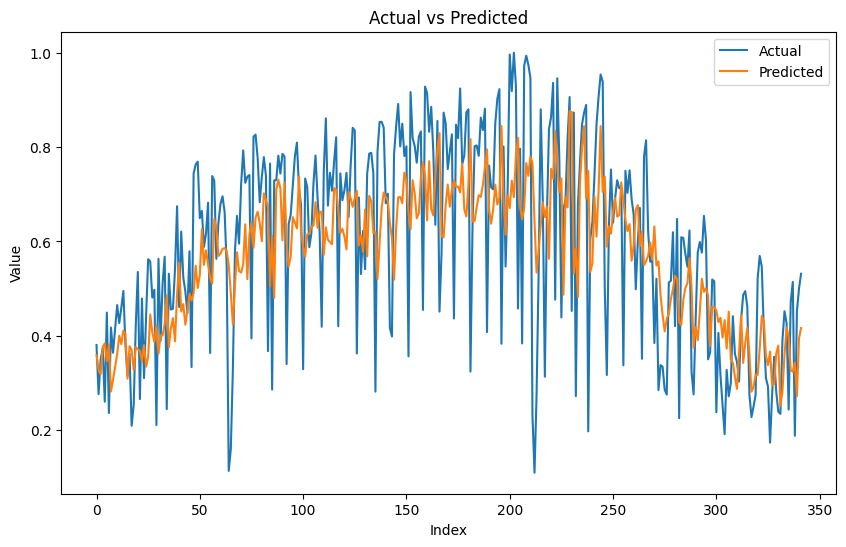

In [120]:

# Assuming X_train, y_train, X_test, y_test are your training and testing data
# Define and compile your Keras model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mse')  # Compile the model

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [121]:
# Prepare data for prediction
# Assuming scaled_data contains your entire dataset (including training and testing data)
data_for_prediction = scaled_data[-look_back:]

# Create an empty list to store predicted values
predicted_values = []

# Loop through the number of days you want to predict (365 days)
for _ in range(365):
    # Reshape the data to match the input shape of the model
    input_data = data_for_prediction.reshape(1, look_back, 1)
    
    # Predict the next day's value
    next_day_prediction = model.predict(input_data)
    
    # Append the predicted value to the list
    predicted_values.append(next_day_prediction[0][0])
    
    # Update data_for_prediction by removing the first value and adding the predicted value
    data_for_prediction = np.append(data_for_prediction[1:], next_day_prediction)

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━

In [122]:
# Define historic data
historic_data = rides_per_date[:-365]  # Assuming the last 365 days are for prediction

# Define predicted data with dates starting from 31.01.2024
predicted_dates = pd.date_range(start='2024-01-31', periods=len(predictions), freq='D')
predicted_data = pd.DataFrame({'started_at': predicted_dates, 'rides': predictions})

# Concatenate historic and predicted data
historic_and_predicted_data = pd.concat([historic_data, predicted_data])

# Plot the historic and predicted data
plt.figure(figsize=(10, 6))
plt.plot(historic_and_predicted_data['started_at'], historic_and_predicted_data['rides'], label='Historic', color='blue')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Historic and Predicted Ride Counts')
plt.legend()
plt.show()


ValueError: Per-column arrays must each be 1-dimensional

Epoch 1/100


C:\Users\lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0764
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0334
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0338
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0308
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0301
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0289
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0316
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0307
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0273
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0276
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0294
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0285
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0295
E

ValueError: x and y must have same first dimension, but have shapes (1857,) and (342, 1)

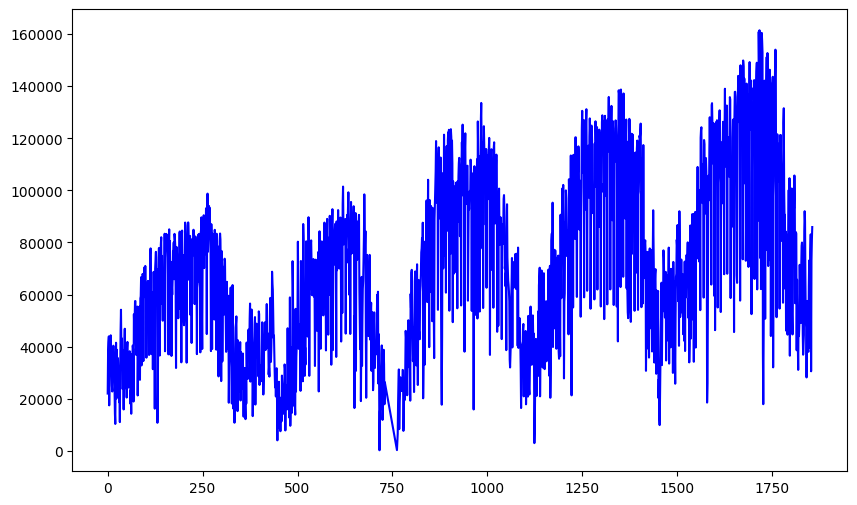

In [129]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, concatenate

# Preprocess your data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(rides_per_date['rides'].values.reshape(-1, 1))

# Assuming daily_dataframe contains weather data
weather_features = daily_dataframe[['daylight_duration', 'sunshine_duration', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours']].values

# Concatenate weather features with the rides data
all_data = np.concatenate((scaled_data, weather_features), axis=1)

# Split data into training and testing sets
train_size = int(len(all_data) * 0.8)
train_data, test_data = all_data[:train_size], all_data[train_size:]

# Define the number of time steps to look back
look_back = 30  # You can adjust this value based on your data and requirements

# Function to create dataset with look back
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, 0])  # First column is the target variable (rides)
    return np.array(X), np.array(y)

# Create dataset with look back
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Evaluate your model
# You can use various metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), etc.
# Evaluate your model using these metrics based on your problem requirements.

# Plot historic data
plt.figure(figsize=(10, 6))
plt.plot(rides_per_date.index, rides_per_date['rides'], label='Historic Data', color='blue')

# Plot forecasted data
plt.plot(rides_per_date.index, predictions, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Ride Counts Over Time')
plt.legend()
plt.show()

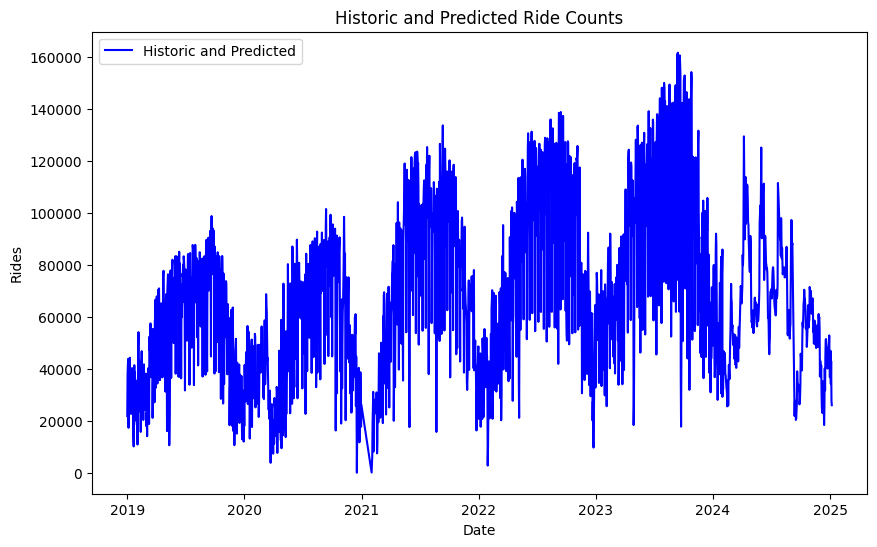

In [126]:

# Assuming rides_per_date contains historic data and predictions is the array of predicted values
historic_data = rides_per_date#[:-365]  # Assuming the last 365 days are for prediction

# Reshape predictions array to be one-dimensional
predictions_1d = predictions.flatten()

# Define predicted data with dates starting from 31.01.2024
predicted_dates = pd.date_range(start='2024-01-31', periods=len(predictions), freq='D')
predicted_data = pd.DataFrame({'started_at': predicted_dates, 'rides': predictions_1d})

# Concatenate historic and predicted data
historic_and_predicted_data = pd.concat([historic_data, predicted_data])

# Plot the historic and predicted data
plt.figure(figsize=(10, 6))
plt.plot(historic_and_predicted_data['started_at'], historic_and_predicted_data['rides'], label='Historic and Predicted', color='blue')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Historic and Predicted Ride Counts')
plt.legend()
plt.show()

Epoch 1/100


C:\Users\lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0577
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0309
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0278
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0296
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0297
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0281
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0274
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0302
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0270
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0295
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0265
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0268
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0263
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0272
E

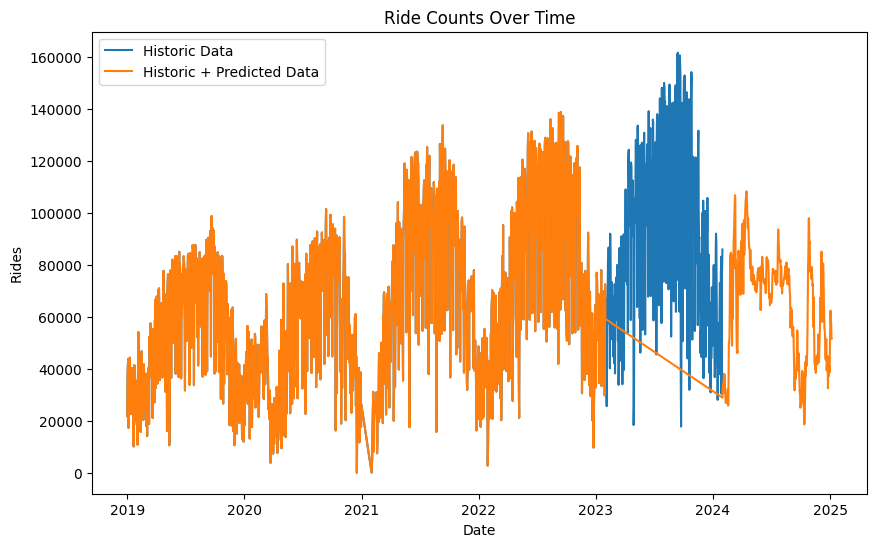

In [127]:

# Preprocess your data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(rides_per_date['rides'].values.reshape(-1, 1))

# Assuming daily_dataframe contains weather data
weather_features = daily_dataframe[['daylight_duration', 'sunshine_duration', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours']].values

# Concatenate weather features with the rides data
all_data = np.concatenate((scaled_data, weather_features), axis=1)

# Split data into training and testing sets
train_size = int(len(all_data) * 0.8)
train_data, test_data = all_data[:train_size], all_data[train_size:]

# Define the number of time steps to look back
look_back = 30  # You can adjust this value based on your data and requirements

# Function to create dataset with look back
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, 0])  # First column is the target variable (rides)
    return np.array(X), np.array(y)

# Create dataset with look back
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Create DataFrame for predictions
predicted_dates = pd.date_range(start='2024-01-31', periods=len(predictions), freq='D')
predicted_data = pd.DataFrame({'started_at': predicted_dates, 'rides': predictions.flatten()})



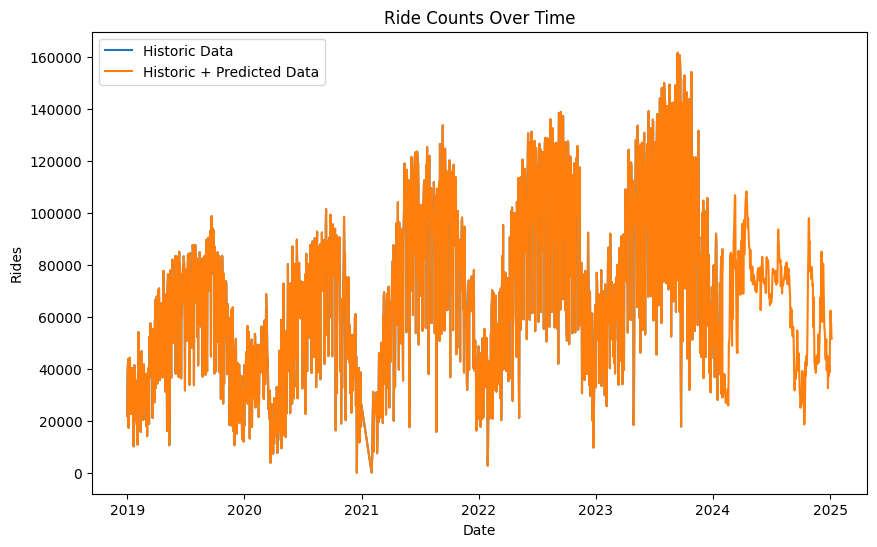

In [128]:
# Concatenate historic and predicted data
historic_and_predicted_data = pd.concat([rides_per_date, predicted_data])

# Plot historic and predicted data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rides_per_date['started_at'], rides_per_date['rides'], label='Historic Data')
plt.plot(historic_and_predicted_data['started_at'], historic_and_predicted_data['rides'], label='Historic + Predicted Data')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.title('Ride Counts Over Time')
plt.legend()
plt.show()